<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

Datensatz erklären, Datenquelle: [kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), Ziel dieses Notebooks (Aufgabenstellung) erläutern

## 0. Package- und Datenimport

In [1]:
import numpy as np
import pandas as pd
import zipfile

In [2]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

train = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monate",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahre",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

C:\Users\nikla\AppData\Local\Temp\ipykernel_9572\2797083622.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


## 1. Deskriptive Analyse

### 1.1 Allgemeines

Was beschreiben die Daten, fehlen Daten, gibt es falsche Werte, . Was können wir aus dieser deskriptiven Analyse über das Problem lernen?

- Was zeigt der Train-Datensatz?
- Was zeigt der Test-Datensatz?
- Was zeigt der Store-Datensatz?

Um ein ersten Gefühl für die Daten zu bekommen, werden im ersten Schritt die ersten fünf Zeilen jedes Datensatzen ausgegeben. Dabei fällt auf, dass sich der Test-Datensatz in den Spalten zum Train-Datensatz unterscheidet. Die Spalte "ID" existiert im Train-Datensatz nicht und die Spalten "Umsatz" und "Kundenanzahl" fehlen im Test-Datensatz. Das fehlen der "Umsatz" Spalte lässt sich damit erklären, dass das Ziel dieser Ausarbeitung die Vorhersage dieser Werte ist.
- Warum fehlt die Spalte Kundenanzahl?

- in den Spalten Aktion_seit_Woche und Aktion_seit_Jahr fehlen Werte, wenn in der Spalte Teilnahme_Langzeitaktion eine 0 eintragen wurde. Die fehlenden werte sollte durch eine 0 ersetzt werden (?)

Desweiteren fällt auf, dass die Spalte "Aktionsmonate" im Store-Datensatz noch überarbeitet werden muss. In dieser Spalte werden die Aktionsmonate mit einem Komma separiert aufgelistet, was für die Vorhersageverfahren im Anschluss schwierig zu verarbeiten ist.

In [3]:
print("\nTrain-Datensatz")
display(train.head())

print("\nTest-Datensatz")
display(test.head())

print("\nStore-Datensatz")
display(store.head())


Train-Datensatz


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



Test-Datensatz


,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0



Store-Datensatz


,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monate,Wettbewerber_Eroeffnet_seit_Jahre,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 1.2 Datentypen und Wertebereiche

Machen alle Datentypen sinn? Welche sollte man ändern und wieso? Wertebereiche?

In [4]:
print("Train-Datensatz")
describe = train.describe(include='all')
dtypes = pd.DataFrame(train.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

print("\nTest-Datensatz")
describe = test.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

print("\nStore-Datensatz")
describe = store.describe(include='all')
dtypes = pd.DataFrame(store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

Train-Datensatz


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,object,int64,int64,int64,int64,object,int64
count,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209.0,1017209.0,1017209,1017209.0
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0



Test-Datensatz


,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,int64,object,float64,int64,object,int64
count,41088.0,41088.0,41088.0,41088,41077.0,41088.0,41088,41088.0
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-17,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.5,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0
25%,10272.75,279.75,2.0,NaN,1.0,0.0,NaN,0.0
50%,20544.5,553.5,4.0,NaN,1.0,0.0,NaN,0.0



Store-Datensatz


,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monate,Wettbewerber_Eroeffnet_seit_Jahre,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
dtypes,int64,object,object,float64,float64,float64,int64,float64,float64,object
count,1115.0,1115,1115,1112.0,761.0,761.0,1115.0,571.0,571.0,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.0,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.17472,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.0,NaN,NaN,20.0,1.0,1900.0,0.0,1.0,2009.0,NaN
25%,279.5,NaN,NaN,717.5,4.0,2006.0,0.0,13.0,2011.0,NaN
50%,558.0,NaN,NaN,2325.0,8.0,2010.0,1.0,22.0,2012.0,NaN


In [5]:
train["Datum"].min(), train["Datum"].max()

('2013-01-01', '2015-07-31')

In [6]:
train.isna().sum()

Filiale         0
Wochentag       0
Datum           0
Umsatz          0
Kundenanzahl    0
Geoeffnet       0
Aktionstag      0
Feiertag        0
Schulferien     0
dtype: int64

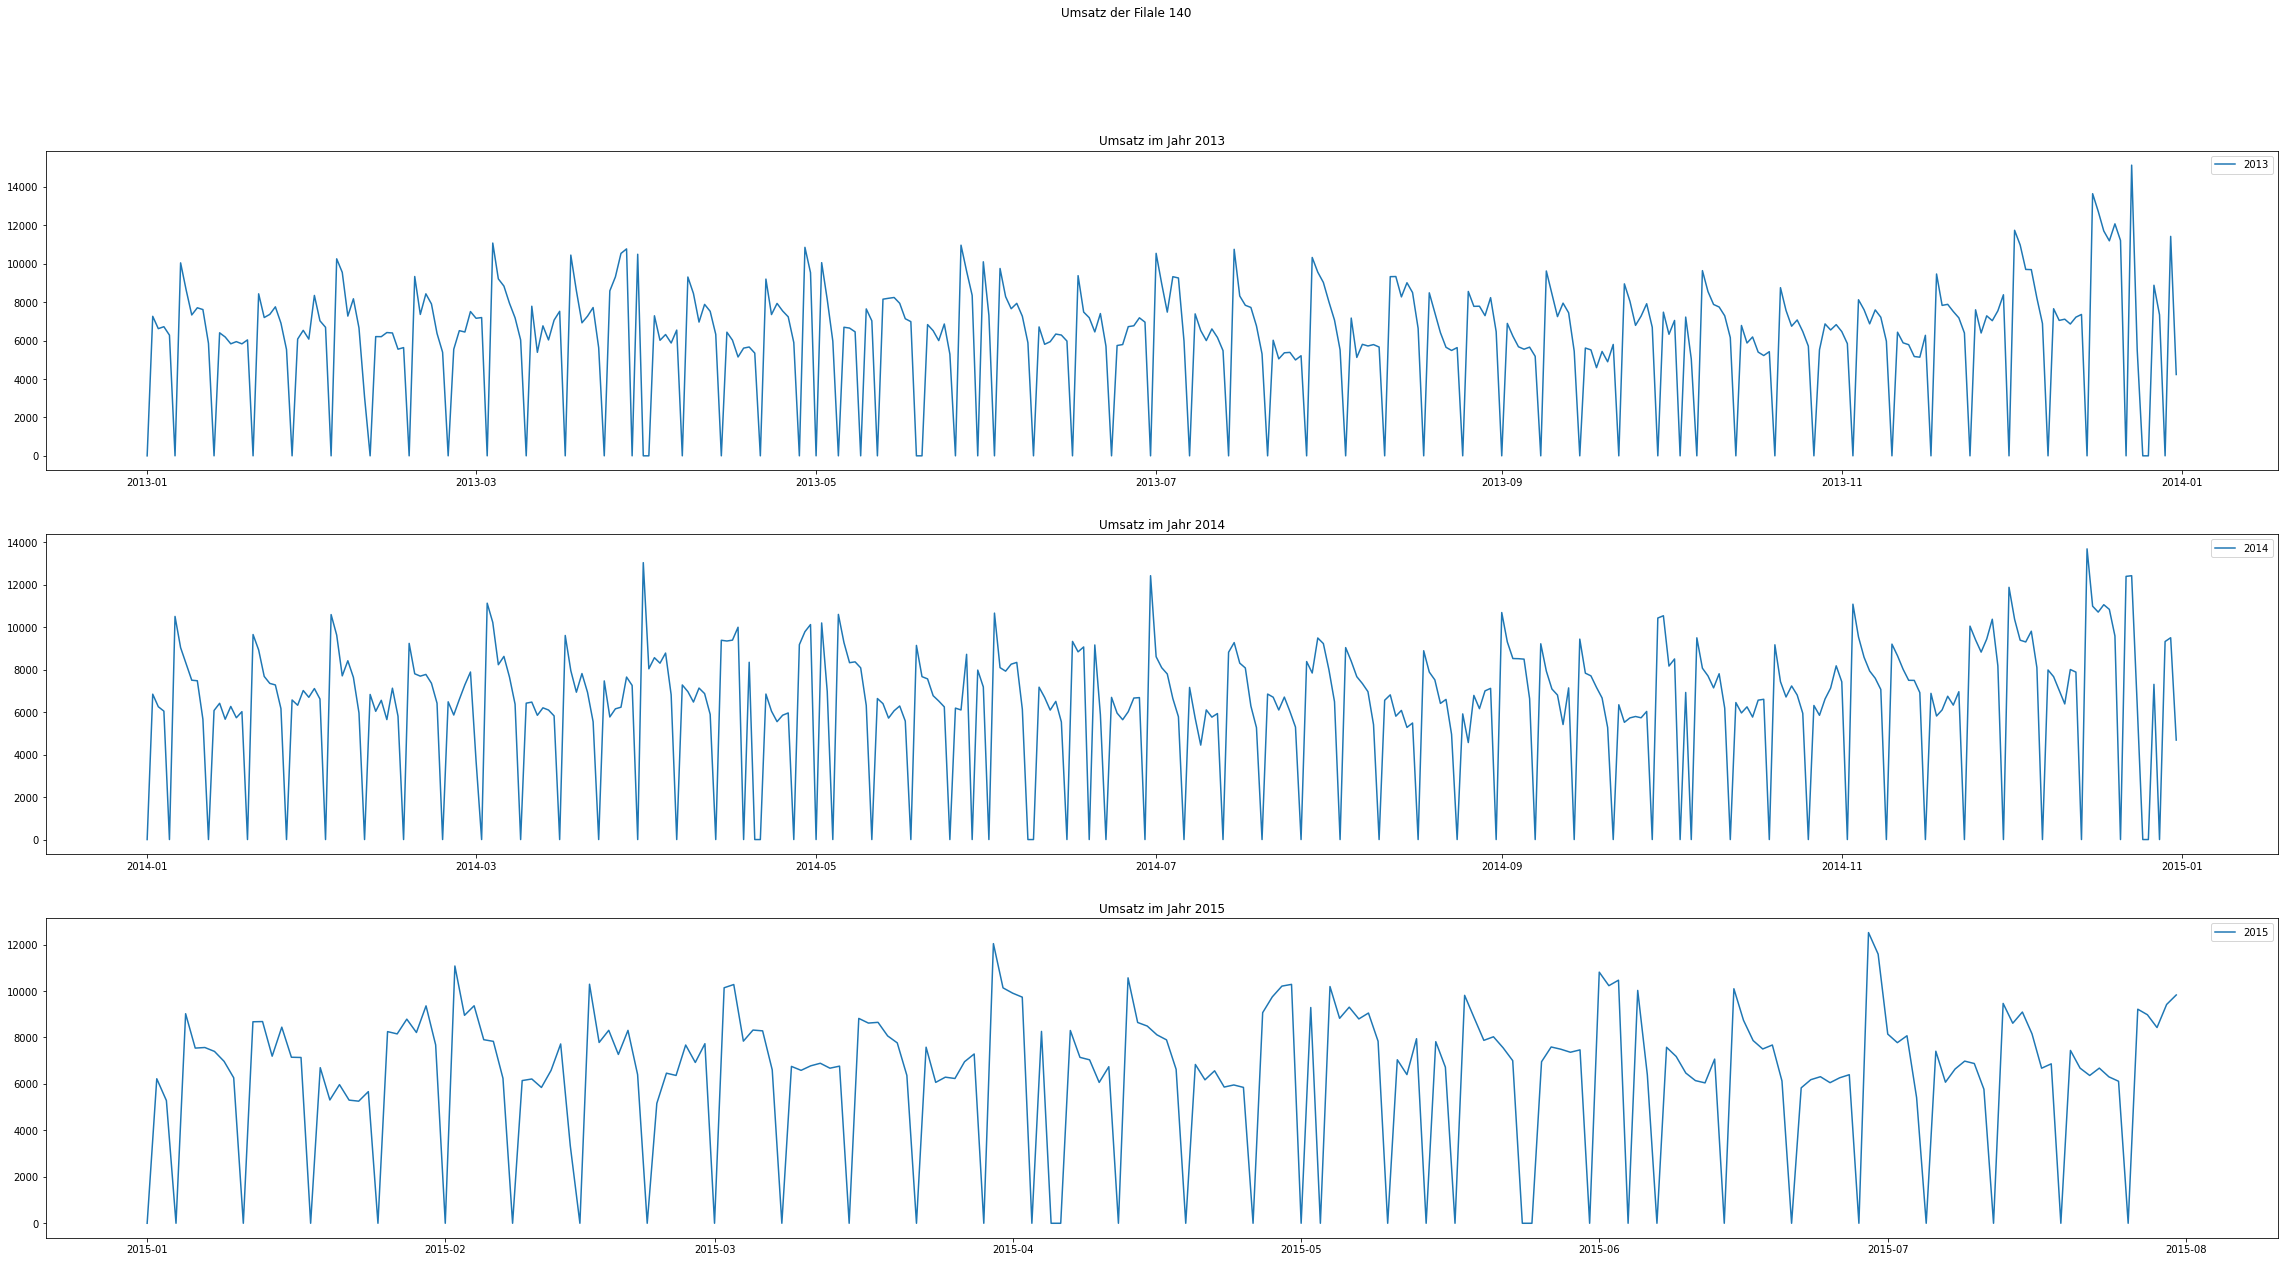

In [7]:
import matplotlib.pyplot as plt

store_id = store["Filiale"].sample(n=1).values[0]
sample = train[train["Filiale"]==store_id].copy()
sample["Datum"] = pd.to_datetime(sample["Datum"])
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)


fig, axs = plt.subplots(3)
fig.set(figheight = 20, figwidth = 40)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

### 1.3 Korrelationen

gibt es Korrelationen zwischen Merkmalen (Features, Spalten)? Benutzen Sie Visualisierungen, wenn es sinnvoll erscheint

## 2. Geeignete Merkmale

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## 3. Modellgüte

## 4. Machine Learning Verfahren 1

## 5. Machine Learning Verfahren 2

## 6. Vergleich der Machine Learning Verfahren